# Part A: Deep Convolutional Neural Network

This project serves as assingment 2 of CZ4042 Neural Network (Nanyang Technological University).

This part of the assignment aims to give you exposure to the use of convolutional neural networks (CNN) for object recognition in images.

The project uses hand-written digit images provided by the MNIST database.
Use only a subset of MNIST data for training and testing and select first 12,000 images from MNIST train data as training dataset and first 2000 of MNIST test data as testing dataset.



## Initialization
To understand the code better, the Convolutional Neural network will be implemented as a class. It give us flexibility in trying different configuration for the network.

### Import

Additional library used for the experiment.

In [1]:
import pickle
import math

import theano
import theano.tensor as T
from theano.tensor.signal import pool
import numpy as np

import matplotlib.pyplot as plt


### CNN Softmax Class

- Flexible layer initialization
- SGD learning (with and without momentum)
- RMSProp learning
- ReLu activation function
- Softmax output

In [2]:
""" Convolutional Neural Network with Softmax output function """

class SoftmaxCNN:
    """ Softmax CNN Class """

    def __init__(self):
        self.conv_layers=[]
        self.pool_layers=[]
        self.hidden_layers=[]
        
        self.train = None
        self.predict = None
        self.test = None
        
        self.learning = None
        self.learning_rate = None
        self.decay = None

        # For SGD learning
        self.momentum = None

        # For RMSProp
        self.rho = None
        self.epsilon = None


    def init_learning_sgd(self, learning_rate=0.05, decay=0.0001, momentum=0.0):
        """ Initialise parameter for SGD learning """
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        
        self.learning = self.sgd
        if momentum > 0.0:
            self.learning = self.sgd_momentum


    def init_learning_RMSProp(self, learning_rate=0.001, decay=0.0001, rho=0.9, epsilon=1e-6):
        """ Initialise parameter for RMSProp learning """
        self.learning_rate = learning_rate
        self.decay = decay
        self.rho = rho
        self.epsilon = epsilon

        self.learning = self.RMSprop


    def create_model(self, convolutional_layer, pooling_layer, hidden_layer, num_output):
        """
        :param convolutional_layer: list of convolutional [(15,1,9,9), (20,1,5,5)] -> first conv 15 kernels
                                    with size 9x9
        :param pooling_layer: list of ppoling layer [(2,2), (2,2)] -> first pool downsizing the cinv by 4x4
                                Notes that the the length of conv and pool layer need to be same
        :param hidden_layer: List of normal full connected layer [100]
        """

        x = T.tensor4('x')
        d = T.matrix('d')

        weights_conv = []
        biases_conv = []

        # size conv and pool is strictly same
        size_conv_pool = len(convolutional_layer)

        prev_output = x

        """
            Construct the Convolutional together with the Pooling Layer
        """

        for i in range(0, size_conv_pool, 1):
            weight_conv, bias_conv = init_weight_biases_4dimension(
                convolutional_layer[i], x.dtype)

            conv_out = T.nnet.relu(T.nnet.conv2d(prev_output, weight_conv) + bias_conv.dimshuffle('x', 0, 'x', 'x'))
            prev_output = pool.pool_2d(conv_out, pooling_layer[i])

            weights_conv.append(weight_conv)
            biases_conv.append(bias_conv)
            self.conv_layers.append(conv_out)
            self.pool_layers.append(prev_output)

        """
            Construct the full connected layer
        """
        prev_output = T.flatten(prev_output, outdim=2)

        weights = []
        biases = []

        for i in range(0, len(hidden_layer), 1):

            weight, bias = init_weight_biases_2dimensions(hidden_layer[i], x.dtype)

            prev_output = T.nnet.relu(T.dot(prev_output, weight) + bias)

            weights.append(weight)
            biases.append(bias)
            self.hidden_layers.append(prev_output)

        weight, bias = init_weight_biases_2dimensions((hidden_layer[-1][1], num_output), x.dtype)

        weights.append(weight)
        biases.append(bias)

        prev_output = T.nnet.softmax(T.dot(prev_output, weight) + bias)

        prediction = T.argmax(prev_output, axis=1)

        cost = T.mean(T.nnet.categorical_crossentropy(prev_output, d))
        params = weights_conv + biases_conv + weights + biases

        updates = self.learning(cost, params)

        outputs = [cost] + self.conv_layers + self.pool_layers + self.hidden_layers
        
        self.train = theano.function(inputs=[x, d], outputs=outputs, updates=updates, allow_input_downcast=True)
        self.predict = theano.function(inputs=[x], outputs=prediction, allow_input_downcast=True)
        self.test = theano.function(inputs=[x], outputs=outputs[1:], allow_input_downcast=True)


    def sgd(self, cost, params):
        """ Learning using SGD """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - (g + self.decay * p) * self.learning_rate])
        return updates


    def sgd_momentum(self, cost, params):
        """ Learning using SGD with momentum """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            v = theano.shared(p.get_value()*0.)
            v_new = self.momentum*v - (g + self.decay*p) * self.learning_rate
            updates.append([p, p + v_new])
            updates.append([v, v_new])
        
        return updates


    def RMSprop(self, cost, params):
        """ Learning using RMSProp """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            acc = theano.shared(p.get_value() * 0.)
            acc_new = self.rho * acc + (1 - self.rho) * g ** 2
            gradient_scaling = T.sqrt(acc_new + self.epsilon)
            g = g / gradient_scaling
            updates.append((acc, acc_new))
            updates.append((p, p - self.learning_rate * (g+ self.decay*p)))
        return updates


    def start_train(self, tr_x, tr_y, te_x, te_y, epochs, batch_size):
        """ Start training based on initialized model """
        self.predictions = []
        self.costs = []

        for i in range(epochs):

            tr_x, tr_y = shuffle_data(tr_x, tr_y)
            te_x, te_y = shuffle_data(te_x, te_y)

            costs = []

            for start, end in zip(range(0, len(tr_x), batch_size), range(batch_size, len(tr_y), batch_size)):
                outputs = self.train(tr_x[start:end], tr_y[start:end])
                costs.append(outputs[0])

            self.predictions.append(np.mean(np.argmax(te_y, axis=1) == self.predict(te_x)))
            self.costs.append(np.mean(costs))

            print('epoch: %d, accuracy: %s, cost: %s \n' % (i+1, self.predictions[i], self.costs[i]))
        
        return self.predictions, self.costs


### Data Colector

Helper to get the train and test data from mnist.pkl

In [3]:
""" 
Data collector for mnist.pkl 
"""

class DataCollector:
    """ DataCollector class """

    def __init__(self, file_path):
        with open(file_path, "rb") as input_file:
            self.data = pickle.load(input_file, encoding="latin-1")

        self.data_train = self.data[0]
        self.data_test = self.data[2]
        self.data_validate = self.data[1]

    def get_train_data(self):
        """ get train data with one hot encoding """
        return self.data_train[0], self.return_one_hot_encoding(10, self.data_train[1])

    def get_test_data(self):
        """ get test data with one hot encoding """
        return self.data_test[0], self.return_one_hot_encoding(10, self.data_test[1])

    def get_validation_data(self):
        """ get validation data with one hot encoding """
        return self.data_validate[0], self.return_one_hot_encoding(10, self.data_validate[1])

    def return_one_hot_encoding(self, num_output, list_data):
        """ One hot encoding """
        zeros = np.zeros((len(list_data), num_output))

        for i in range(len(zeros)):
            zeros[i][list_data[i]] = 1

        return zeros


### Data Visualization

Visualize the data as graphs or image

In [4]:
""" Data Visualization for CNN Softmax """

class DataVisualization:
    """
    Data Visualizer
    - Graph visualizer
    - Image visualizer
    """ 

    def __init__(self):
       return

    def plot_graphs(self, list_x_point, list_y_point, x_label, y_label, title, figure_name="", show_image=True):
        """ Plot graphs from data"""
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        
        if figure_name != "":
            plt.savefig(figure_name)
        
        if show_image:
            plt.show()


    def plot_images(self, data, figure_name="", number_column=10, limit_image=20, size=28, transpose=True, show_image=True):
        """ Plot images from data"""
        width = height = size

        plt.figure()
        plt.gray()
        row = limit_image/number_column

        for i in range(1, limit_image+1):
            plt.subplot(row, number_column, i)
            plt.axis('off')
            if transpose:
                norm_image = self.normalize_image(data[:, i-1].reshape(width, height))
            else:
                norm_image = self.normalize_image(data[i-1].reshape(width, height))
            plt.imshow(norm_image)

        if figure_name != "":
            plt.savefig(figure_name)
        
        if show_image:
            plt.show()


    def normalize_image(self, image):
        """ Normalize image data """
        min_val = np.min(image)
        max_val = np.max(image)

        return (image-min_val)/(max_val-min_val)


### Utility

Additional utility functions used in the experiment

In [5]:
""" Utility function for CNN Softmax
- Weights and biases 4d initialization
- Weights and biases 2d initialization
- Shufle data
"""


def init_weight_biases_4dimension(filter_shape, d_type):
    """ Initialized 4d weights and biases """
    fan_in = np.prod(filter_shape[1:])
    fan_out = filter_shape[0] * np.prod(filter_shape[2:])

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[0],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def init_weight_biases_2dimensions(filter_shape, d_type):
    """ Initialized 2d weights and biases """
    fan_in = filter_shape[1]
    fan_out = filter_shape[0]

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[1],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def shuffle_data(samples, labels):
    """ Shuffle data """
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    samples, labels = samples[idx], labels[idx]
    return samples, labels


## Question 1
To recognize MNIST digits, design a convolutional neural network consisting of

- An Input layer of 28x28 dimensions
- A convolution layer C1 of 15 feature maps and filters of window size 9x9. A max pooling layer S1 with a pooling window of size 2x2.
- A convolution layer C2 of 20 feature maps and filters of window size 5x5. A max pooling layer S2 with a pooling window of size 2x2.
- A fully connected layer F3 of size 100.
- A softmax layer F4 of size 10.

Train the network using ReLu activation functions for neurons and mini batch gradient descent learning. Set batch size 128, learning rate (alpha) = 0.05 and decay parameter (beta) = 10−4. 

- Plot the training cost and test accuracy with learning epochs.
- For two representative test patterns, plot the feature maps at the convolution and pooling layers.

Start question 1!


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


epoch: 1, accuracy: 0.771, cost: 1.57470124863 

epoch: 2, accuracy: 0.8755, cost: 0.486557938176 

epoch: 3, accuracy: 0.891, cost: 0.288030075158 

epoch: 4, accuracy: 0.9245, cost: 0.219894514754 

epoch: 5, accuracy: 0.932, cost: 0.181146604958 

epoch: 6, accuracy: 0.944, cost: 0.150561180992 

epoch: 7, accuracy: 0.95, cost: 0.133928199676 

epoch: 8, accuracy: 0.9495, cost: 0.120460049202 

epoch: 9, accuracy: 0.9555, cost: 0.107760937203 

epoch: 10, accuracy: 0.95, cost: 0.0994392103759 



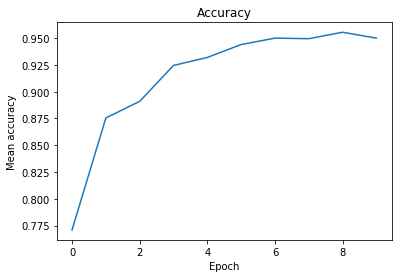

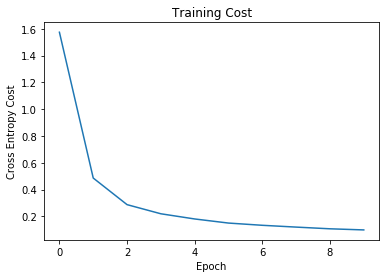

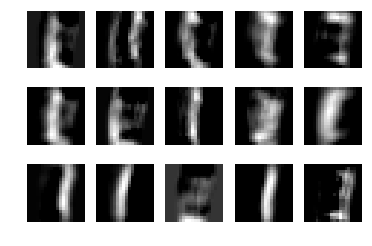

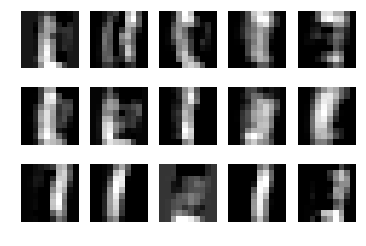

Finished question 1


In [6]:
""" 
Start script question 1
""" 

# import numpy as np
# from project_a.cnn_softmax import SoftmaxCNN
# from project_a.data_collector import DataCollector
# from project_a.data_visualization import DataVisualization

def question1():
    """ question 1 """
    print("Start question 1!")
    np.random.seed(10)

    batch_size = 128
    epoch = 10

    learning_rate = 0.05
    decay = 0.0001

    data_collector = DataCollector("../data/mnist.pkl")
    graph_visualizer = DataVisualization()

    trX, trY = data_collector.get_train_data()
    teX, teY = data_collector.get_test_data()

    trX = trX.reshape(-1, 1, 28, 28)
    teX = teX.reshape(-1, 1, 28, 28)

    trX, trY = trX[:12000], trY[:12000]
    teX, teY = teX[:2000], teY[:2000]

    """ 
    Question 1: SGD
    """
    cnn = SoftmaxCNN()
    cnn.init_learning_sgd(learning_rate, decay)
    cnn.create_model(
        convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
        pooling_layer=[(2, 2), (2, 2)],
        hidden_layer=[(20*3*3, 100)],
        num_output=10)
    accuracy, costs = cnn.start_train(trX, trY, teX, teY, epoch, batch_size)
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=accuracy,
        x_label="Epoch",
        y_label="Mean accuracy",
        title="Accuracy",
        figure_name="../data/Figure1.1-AccuracyEpoch.png",
        show_image=False
    )
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=costs,
        x_label="Epoch",
        y_label="Cross Entropy Cost",
        title="Training Cost",
        figure_name="../data/Figure1.2-CostEpoch.png",
        show_image=False
    )

    ind = np.random.randint(low=0, high=2000)
    outputs = cnn.test(teX[ind:ind+1,:])
    graph_visualizer.plot_images(
        outputs[0], figure_name="../data/Figure1.3.1-ConvLayer1.png", 
        number_column=5, limit_image=15, size=20
    )
    # graph_visualizer.plot_images(
    #     outputs[1], figure_name="../data/Figure1.3.3-ConvLayer2.png", 
    #     number_column=5, limit_image=20, size=6
    # )
    graph_visualizer.plot_images(
        outputs[2], figure_name="../data/Figure1.3.2-PoolLayer1.png", 
        number_column=5, limit_image=15, size=10
    )
    # graph_visualizer.plot_images(
    #     outputs[3], figure_name="../data/Figure1.3.4-PoolLayer2.png", 
    #     number_column=5, limit_image=20, size=3
    # )

    print("Finished question 1")


if __name__ == "__main__":
    question1()


## Question 2
Repeat part 1 by adding the momentum term to mini batch gradient descent learning with momentum parameter (gamma) = 0.1.

Start question 2!


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


epoch: 1, accuracy: 0.782, cost: 1.49158686684 

epoch: 2, accuracy: 0.8755, cost: 0.436087796587 

epoch: 3, accuracy: 0.905, cost: 0.269748889175 

epoch: 4, accuracy: 0.9245, cost: 0.205985676868 

epoch: 5, accuracy: 0.936, cost: 0.171519929908 

epoch: 6, accuracy: 0.943, cost: 0.142703804659 

epoch: 7, accuracy: 0.952, cost: 0.126363687219 

epoch: 8, accuracy: 0.952, cost: 0.112635570084 

epoch: 9, accuracy: 0.9545, cost: 0.100569370564 

epoch: 10, accuracy: 0.9515, cost: 0.0922465155431 



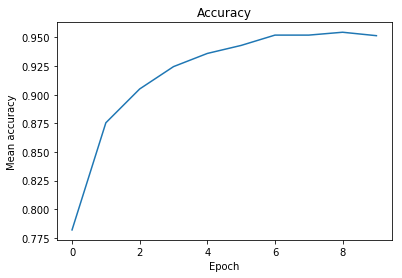

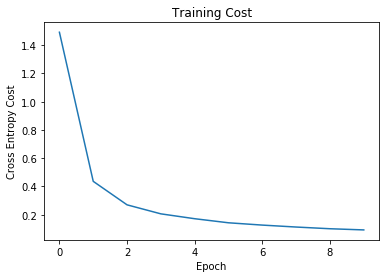

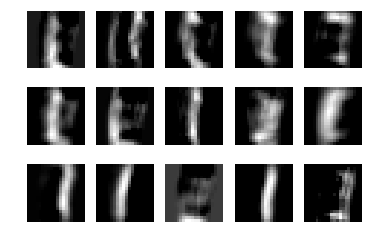

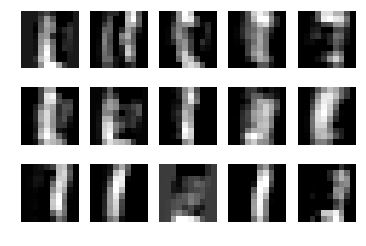

Finished question 2


In [7]:
""" 
Start script question 2
""" 

# import numpy as np
# from project_a.cnn_softmax import SoftmaxCNN
# from project_a.data_collector import DataCollector
# from project_a.data_visualization import DataVisualization

def question2():
    """ question 2 """
    print("Start question 2!")
    np.random.seed(10)

    batch_size = 128
    epoch = 10

    learning_rate = 0.05
    decay = 0.0001
    momentum = 0.1

    data_collector = DataCollector("../data/mnist.pkl")
    graph_visualizer = DataVisualization()

    trX, trY = data_collector.get_train_data()
    teX, teY = data_collector.get_test_data()

    trX = trX.reshape(-1, 1, 28, 28)
    teX = teX.reshape(-1, 1, 28, 28)

    trX, trY = trX[:12000], trY[:12000]
    teX, teY = teX[:2000], teY[:2000]

    """
    Question 2: SGD with momentum
    """
    cnn2 = SoftmaxCNN()
    cnn2.init_learning_sgd(learning_rate, decay, momentum)
    cnn2.create_model(
        convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
        pooling_layer=[(2, 2), (2, 2)],
        hidden_layer=[(20*3*3, 100)],
        num_output=10)
    accuracy, costs = cnn2.start_train(trX, trY, teX, teY, epoch, batch_size)
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=accuracy,
        x_label="Epoch",
        y_label="Mean accuracy",
        title="Accuracy",
        figure_name="../data/Figure2.1-AccuracyEpoch.png",
        show_image=False
    )
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=costs,
        x_label="Epoch",
        y_label="Cross Entropy Cost",
        title="Training Cost",
        figure_name="../data/Figure2.2-CostEpoch.png",
        show_image=False
    )

    ind = np.random.randint(low=0, high=2000)
    outputs = cnn2.test(teX[ind:ind+1,:])
    graph_visualizer.plot_images(
        outputs[0], figure_name="../data/Figure2.3.1-ConvLayer1.png", 
        number_column=5, limit_image=15, size=20
    )
    # graph_visualizer.plot_images(
    #     outputs[1], figure_name="../data/Figure2.3.3-ConvLayer2.png", 
    #     number_column=5, limit_image=20, size=6
    # )
    graph_visualizer.plot_images(
        outputs[2], figure_name="../data/Figure2.3.2-PoolLayer1.png", 
        number_column=5, limit_image=15, size=10
    )
    # graph_visualizer.plot_images(
    #     outputs[3], figure_name="../data/Figure2.3.4-PoolLayer2.png", 
    #     number_column=5, limit_image=20, size=3
    # )


    print("Finished question 2")


if __name__ == "__main__":
    question2()


## Question 3
Repeat part 1 by using RMSProp algorithm for learning. Use learning rate = 0.001, decay = 0.0001 , rho = 0.9,
and epsilon = 0.000001 for RMSProp.

Start question 3!


D:\Data\github\neural_network_deep_cnn_autoencoder\project_a\cnn_softmax.py:85: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
  prev_output = pool.pool_2d(conv_out, pooling_layer[i])


epoch: 1, accuracy: 0.8655, cost: 0.869906311347 

epoch: 2, accuracy: 0.9005, cost: 0.302201330039 

epoch: 3, accuracy: 0.9295, cost: 0.201536672527 

epoch: 4, accuracy: 0.94, cost: 0.145230974857 

epoch: 5, accuracy: 0.9505, cost: 0.117188539902 

epoch: 6, accuracy: 0.961, cost: 0.0949846915962 

epoch: 7, accuracy: 0.963, cost: 0.0784459311515 

epoch: 8, accuracy: 0.967, cost: 0.067614151427 

epoch: 9, accuracy: 0.967, cost: 0.0597338944993 

epoch: 10, accuracy: 0.955, cost: 0.0520650769263 



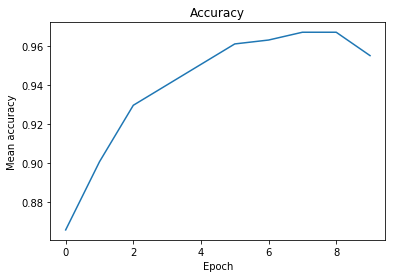

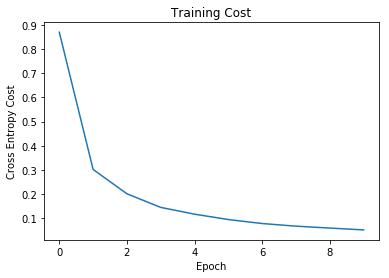

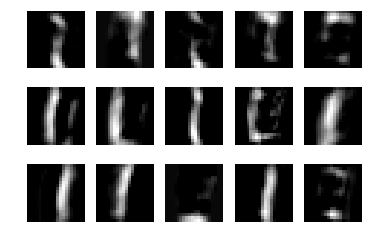

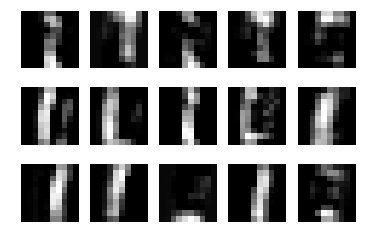

Finished question 3


In [8]:
""" 
Start script question 3
""" 

import numpy as np
from project_a.cnn_softmax import SoftmaxCNN
from project_a.data_collector import DataCollector
from project_a.data_visualization import DataVisualization

def question3():
    """ question 3 """
    print("Start question 3!")
    np.random.seed(10)

    batch_size = 128
    epoch = 10

    learning_rate = 0.001
    decay = 0.0001
    rho = 0.9
    epsilon = 1e-6

    data_collector = DataCollector("../data/mnist.pkl")
    graph_visualizer = DataVisualization()

    trX, trY = data_collector.get_train_data()
    teX, teY = data_collector.get_test_data()

    trX = trX.reshape(-1, 1, 28, 28)
    teX = teX.reshape(-1, 1, 28, 28)

    trX, trY = trX[:12000], trY[:12000]
    teX, teY = teX[:2000], teY[:2000]

    """
    Question 3: RPMS Prop
    """
    cnn3 = SoftmaxCNN()
    cnn3.init_learning_RMSProp(learning_rate, decay, rho, epsilon)
    cnn3.create_model(
        convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
        pooling_layer=[(2, 2), (2, 2)],
        hidden_layer=[(20*3*3, 100)],
        num_output=10)
    accuracy, costs = cnn3.start_train(trX, trY, teX, teY, epoch, batch_size)
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=accuracy,
        x_label="Epoch",
        y_label="Mean accuracy",
        title="Accuracy",
        figure_name="../data/Figure3.1-AccuracyEpoch.png",
        show_image=False
    )
    graph_visualizer.plot_graphs(
        list_x_point=range(epoch),
        list_y_point=costs,
        x_label="Epoch",
        y_label="Cross Entropy Cost",
        title="Training Cost",
        figure_name="../data/Figure3.2-CostEpoch.png",
        show_image=False
    )

    ind = np.random.randint(low=0, high=2000)
    outputs = cnn3.test(teX[ind:ind+1,:])
    graph_visualizer.plot_images(
        outputs[0], figure_name="../data/Figure2.3.1-ConvLayer1.png", 
        number_column=5, limit_image=15, size=20
    )
    # graph_visualizer.plot_images(
    #     outputs[1], figure_name="../data/Figure2.3.3-ConvLayer2.png", 
    #     number_column=5, limit_image=20, size=6
    # )
    graph_visualizer.plot_images(
        outputs[2], figure_name="../data/Figure2.3.2-PoolLayer1.png", 
        number_column=5, limit_image=15, size=10
    )
    # graph_visualizer.plot_images(
    #     outputs[3], figure_name="../data/Figure2.3.4-PoolLayer2.png", 
    #     number_column=5, limit_image=20, size=3
    # )


    print("Finished question 3")


if __name__ == "__main__":
    question3()
